# 📖 Import Library 

In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 💻 Load in data from data that I stimulate earlier 

In [276]:
df=pd.read_csv('../datasets/poker_states.csv')

# 📌 Check the data 
- There are originally 10 columns with 83,630 rows
- There are 2 features that having NaN
    - `community_cards`: Missing values might occur before any community cards are revealed (pre-flop).
    - `actions_this_street`: Missing values might occur when no actions have been taken yet. For instance, at the start of a betting round.
If the missing values have a specific context (e.g., logical absence), treat them differently than random missingness.

In [278]:
df.head()

,config_id,round,acting_player,action,action_amount,hole_cards,community_cards,pot,stacks,actions_this_street
0,0,preflop,geqao,call,200,"ST,S4",NaN,300,5000;4900;4800;5000,smmpihzszsesmpxjefwcwu:SMALLBLIND:100;eavjfjqe...
1,0,preflop,ufrlx,fold,0,"C2,D5",NaN,500,5000;4900;4800;4800,smmpihzszsesmpxjefwcwu:SMALLBLIND:100;eavjfjqe...
2,0,preflop,smmpi,call,200,"HA,D7",NaN,500,5000;4900;4800;4800,smmpihzszsesmpxjefwcwu:SMALLBLIND:100;eavjfjqe...
3,0,preflop,eavjf,call,200,"C8,D8",NaN,600,5000;4800;4800;4800,smmpihzszsesmpxjefwcwu:SMALLBLIND:100;eavjfjqe...
4,0,flop,smmpi,raise,2128,"HA,D7","H4,H3,HQ",600,5000;4800;4800;4800,NaN


In [279]:
df.shape

(83630, 10)

In [280]:
df.columns

Index(['config_id', 'round', 'acting_player', 'action', 'action_amount',
       'hole_cards', 'community_cards', 'pot', 'stacks',
       'actions_this_street'],
      dtype='object')

In [281]:
df.isnull().sum()

config_id                  0
round                      0
acting_player              0
action                     0
action_amount              0
hole_cards                 0
community_cards        64994
pot                        0
stacks                     0
actions_this_street     9082
dtype: int64

### 🔎 Investigate missing values 

### `community_cards`

In [284]:
# Count rows where round is 'preflop' and community_cards is NaN
df[(df['round'] == 'preflop') & (df['community_cards'].isna())].shape[0]

# This can confirm that missing values occur before any community cards are revealed (pre-flop).

64994

In [285]:
# Check  the percentage of each action each happen during preflop round 
print(df[df['round'] == 'preflop'].groupby('config_id')['action'].value_counts(normalize=True).unstack(fill_value=0))

action         call      fold     raise
config_id                              
0          0.335260  0.335472  0.329268
1          0.329375  0.335852  0.334773
2          0.336726  0.331228  0.332047
3          0.333964  0.333853  0.332183


In [286]:
# The percentage of each action is balance. 
# I will replace missing value of `community_cards` to "preflop_state"
df['community_cards'] = df['community_cards'].fillna("preflop_state")

### `actions_this_street`

In [288]:
#Check if missing values correlate with specific rounds (round column) or game states
df[df['actions_this_street'].isna()]['round'].value_counts()

round
flop     6938
turn     1722
river     422
Name: count, dtype: int64

In [289]:
# Understand the missingness of `action_this_street`
# round
# flop     6938 (Most common)
# turn     1722
# river     422 (Least common)

# Possible causes:
# Early termination of hands during preflop round
# Hands end due to flop action
# Hand beaten or beats by river hand
# Situations where multiple players only performed checks without significant bets or raises.

In [290]:
# I want to focus on complete round therefore, I decide to drop the `actions_this_street` rows where contain NaN 

# Reasons:
# It minimize the missing values
# Allow the better detection of player strategies, behavioral patterns, and game dynamics.
# Enhances ability to train models that effectively capture patterns in poker strategies.

In [291]:
# Create new DataFrame to store data and filter out the rows that have NaN in `actions_this_street`
df_complete_games = df.dropna(subset=['actions_this_street'])

In [292]:
# Check data again
df_complete_games.isnull().sum() 

config_id              0
round                  0
acting_player          0
action                 0
action_amount          0
hole_cards             0
community_cards        0
pot                    0
stacks                 0
actions_this_street    0
dtype: int64

---

# 📊 EDA
### Let's see general information

In [295]:
# How many action take place
df_complete_games.groupby('action').size()
# Didn't see huge imbalance in action

action
call     24891
fold     24962
raise    24695
dtype: int64

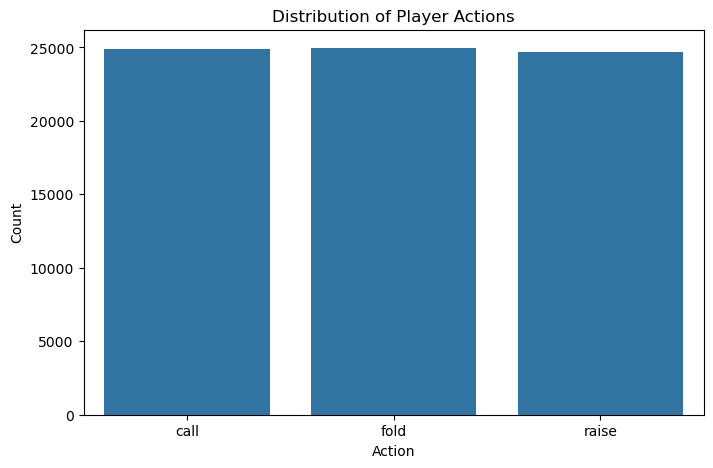

In [332]:
# Plot the distribution of actions
plt.figure(figsize=(8, 5))
sns.countplot(x='action', data=df_complete_games)
plt.title('Distribution of Player Actions')
plt.xlabel('Action')
plt.ylabel('Count')

plt.savefig('../images/Distribution_ofPlayerActions.png', format='png', dpi=300)
plt.show()


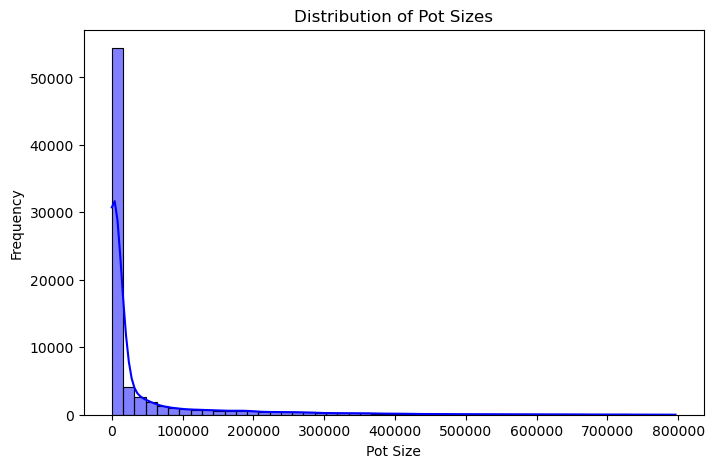

In [334]:
# Plot distribution of pot sizes
plt.figure(figsize=(8, 5))
sns.histplot(df_complete_games['pot'], kde=True, color="blue", bins=50)
plt.title('Distribution of Pot Sizes')
plt.xlabel('Pot Size')
plt.ylabel('Frequency')

plt.savefig('../images/Distribution_ofPotSizes.png', format='png', dpi=300)
plt.show()

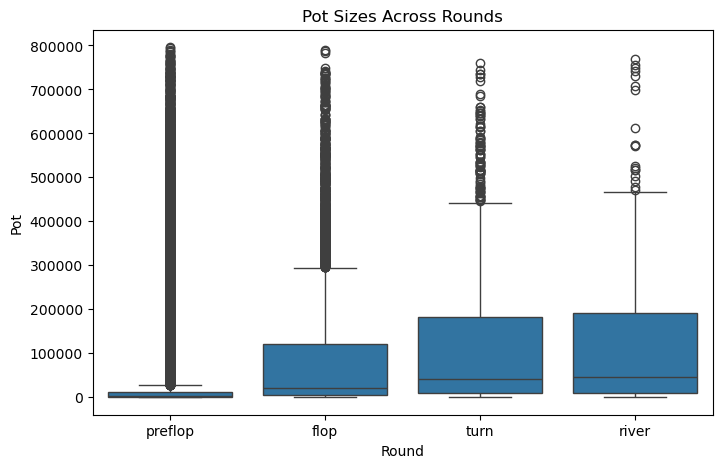

In [336]:
# Compare pot sizes across rounds
plt.figure(figsize=(8, 5))
sns.boxplot(x='round', y='pot', data=df_complete_games)
plt.title('Pot Sizes Across Rounds')
plt.xlabel('Round')
plt.ylabel('Pot')

plt.savefig('../images/PotSizesAcrossRounds.png', format='png', dpi=300)
plt.show()

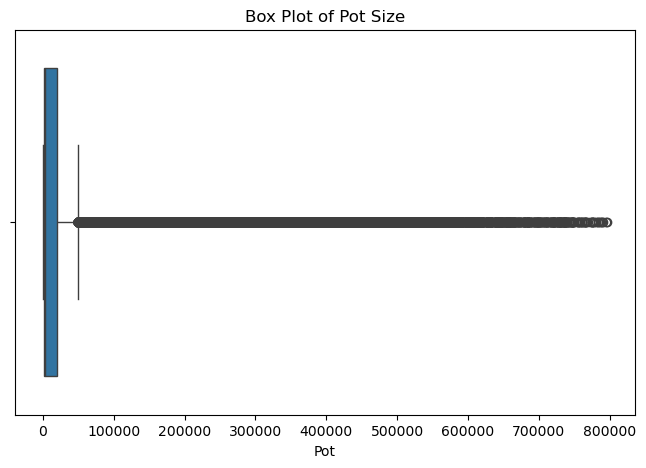

In [338]:
# Visualize outliers in pot sizes
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_complete_games['pot'])
plt.title('Box Plot of Pot Size')
plt.xlabel('Pot')

plt.savefig('../images/Boxplot_ofPotSizes.png', format='png', dpi=300)
plt.show()

In [340]:
df_complete_games.to_csv('../datasets/poker_completed_games.csv', index=False)